In [1]:
# colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Unet - Chest CT Dataset

## 데이터 전처리

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision import models

import os
import numpy as np
import pandas as pd
import shutil
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

from IPython import display
from PIL import Image

### kaggle datasets Download
- 데이터 : Chest CT Segmentation(Chest CT scans together with segmentation masks for lung, heart, and trachea)
- 캐글 데이터 주소: https://www.kaggle.com/datasets/polomarco/chest-ct-segmentation

In [3]:
!pip install kaggle --upgrade

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seonyong","key":"15cdbf608ae7dcc43e31d8ac3e790795"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!mkdir './chestct'
%cd chestct/

/content/chestct


In [7]:
!kaggle datasets download -d polomarco/chest-ct-segmentation

100% 1.61G/1.61G [01:22<00:00, 13.9MB/s]
100% 1.61G/1.61G [01:22<00:00, 20.8MB/s]


In [9]:
!unzip -qq '/content/chestct/chest-ct-segmentation.zip'
%cd ..

/content


In [10]:
data_raw = pd.read_csv('/content/chestct/train.csv')
data_raw.head()

,ImageId,MaskId
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg


In [11]:
data_raw.shape

(16708, 2)

In [12]:
def get_id(x):
    return x.split('_')[0]

data_raw['id'] = data_raw.ImageId.apply(lambda x: get_id(x))
data_raw.head()

,ImageId,MaskId,id
0,ID00007637202177411956430_0.jpg,ID00007637202177411956430_mask_0.jpg,ID00007637202177411956430
1,ID00007637202177411956430_1.jpg,ID00007637202177411956430_mask_1.jpg,ID00007637202177411956430
2,ID00007637202177411956430_2.jpg,ID00007637202177411956430_mask_2.jpg,ID00007637202177411956430
3,ID00007637202177411956430_3.jpg,ID00007637202177411956430_mask_3.jpg,ID00007637202177411956430
4,ID00007637202177411956430_4.jpg,ID00007637202177411956430_mask_4.jpg,ID00007637202177411956430


In [13]:
cli_ids = data_raw.id.unique()
len(cli_ids)

112

In [14]:
print(len(os.listdir('/content/chestct/images/images')), len(os.listdir('/content/chestct/masks/masks')))

17011 16708


In [15]:
cli_id = -1
cli_data = data_raw[data_raw.id == cli_ids[cli_id]]
cli_data

,ImageId,MaskId,id
16300,ID00426637202313170790466_0.jpg,ID00426637202313170790466_mask_0.jpg,ID00426637202313170790466
16301,ID00426637202313170790466_1.jpg,ID00426637202313170790466_mask_1.jpg,ID00426637202313170790466
16302,ID00426637202313170790466_2.jpg,ID00426637202313170790466_mask_2.jpg,ID00426637202313170790466
16303,ID00426637202313170790466_3.jpg,ID00426637202313170790466_mask_3.jpg,ID00426637202313170790466
16304,ID00426637202313170790466_4.jpg,ID00426637202313170790466_mask_4.jpg,ID00426637202313170790466
...,...,...,...
16703,ID00426637202313170790466_403.jpg,ID00426637202313170790466_mask_403.jpg,ID00426637202313170790466
16704,ID00426637202313170790466_404.jpg,ID00426637202313170790466_mask_404.jpg,ID00426637202313170790466
16705,ID00426637202313170790466_405.jpg,ID00426637202313170790466_mask_405.jpg,ID00426637202313170790466
16706,ID00426637202313170790466_406.jpg,ID00426637202313170790466_mask_406.jpg,ID00426637202313170790466


In [19]:
def get_cli_data(data_raw, cli_id):
    cli_ids = data_raw.id.unique()
    cli_data = data_raw[data_raw.id == cli_ids[cli_id]]

    image_file = cli_data.ImageId.values
    mask_file = cli_data.MaskId.values
    id_file = cli_data.id.values[0]

    return id_file, image_file, mask_file

In [20]:
data_dir = '/content/chestct'

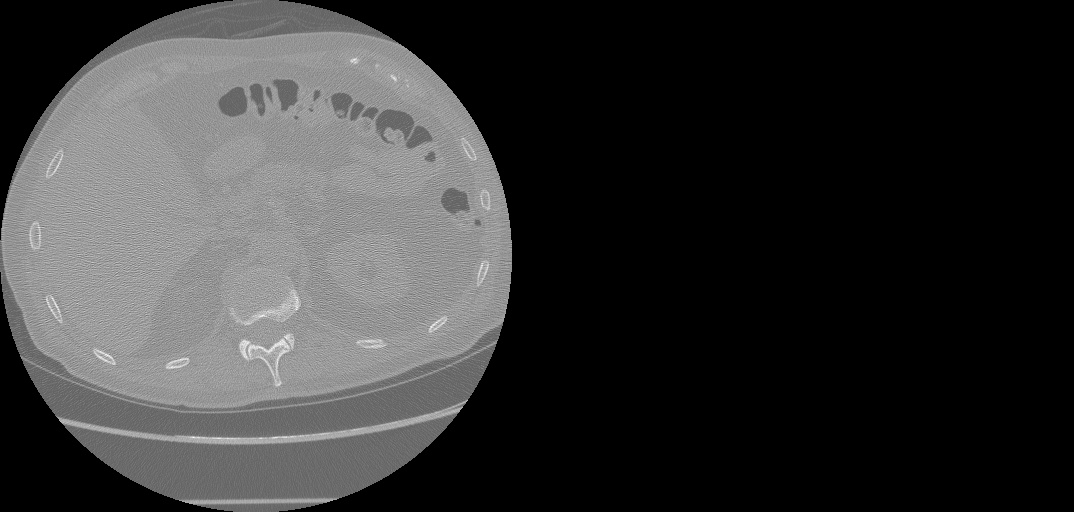

In [33]:
idx = 0
cli_id, image_files, mask_files = get_cli_data(data_raw, idx)
canvas = np.zeros(shape=(512, 512*2+50, 3), dtype=np.uint8)

for i in range(len(image_files)):
    image = cv2.imread(os.path.join(data_dir, 'images', 'images', image_files[i]))
    mask = cv2.imread(os.path.join(data_dir, 'masks', 'masks', mask_files[i]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    canvas[:, :512, :] = image
    canvas[:, 512+50:512*2+50, :] = mask

    # cv2.imshow('image', canvas)
    cv2_imshow(canvas)
    display.clear_output(wait=True)
    key = cv2.waitKey(1)
    if key == 27:
        break
    if key == ord('s'):
        cv2.waitkey(0)
cv2.destroyAllWindows()

## 데이터셋 구축


- 이미지와 마스크 파일이 하나로 묶여 있어, train, val, test 세트로 분리를 필요

In [34]:
!mkdir data

In [35]:
%cd data

/content/data


- 디렉토리 만들기

In [36]:
!mkdir 'train' 'val' 'test'

In [37]:
!mkdir 'train/images' 'train/masks' 'val/images' 'val/masks' 'test/images' 'test/masks'

- 'id'를 기준으로 분리- train, val, test 비율: 0.8, 0.1, 0.1
- 'id'는 총 112개

In [38]:
%cd ..
len(cli_ids)

/content


112

In [39]:
# 데이터셋 나누기
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(cli_ids) * split_ratio[0])
val_len = int(len(cli_ids) * split_ratio[1])
test_len = len(cli_ids) - train_len - val_len

print('{}, {}, {}'.format(train_len, val_len, test_len))

train_ids = []
val_ids = []
test_ids = []

for i in range(len(cli_ids)):
    if 0 <= i < train_len:
        train_ids.append(cli_ids[i])
    elif train_len <= i < train_len + val_len:
        val_ids.append(cli_ids[i])
    elif train_len + val_len <= i:
        test_ids.append(cli_ids[i])

print('{}, {}, {}'.format(len(train_ids), len(val_ids), len(test_ids)))

89, 11, 12
89, 11, 12


- 각각 이미지에서 나눈 'id'를 기준으로 각 디렉토리에 file 복사하기

In [40]:
data_dir = '/content/data'

In [41]:
# train/image
to_file_path = '/content/data/train/images/'
from_file_path = '/content/chestct/images/images/'

for file_name in os.listdir('/content/chestct/images/images'):
    for id in train_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [42]:
#train/mask
to_file_path = '/content/data/train/masks/'
from_file_path = '/content/chestct/masks/masks/'

for file_name in os.listdir('/content/chestct/masks/masks'):
    for id in train_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [43]:
# val/image
to_file_path = '/content/data/val/images/'
from_file_path = '/content/chestct/images/images/'

for file_name in os.listdir('/content/chestct/images/images'):
    for id in val_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [44]:
#val/mask
to_file_path = '/content/data/val/masks/'
from_file_path = '/content/chestct/masks/masks/'

for file_name in os.listdir('/content/chestct/masks/masks'):
    for id in val_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [45]:
# test/image
to_file_path = '/content/data/test/images/'
from_file_path = '/content/chestct/images/images/'

for file_name in os.listdir('/content/chestct/images/images'):
    for id in test_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

In [46]:
#test/mask
to_file_path = '/content/data/test/masks/'
from_file_path = '/content/chestct/masks/masks/'

for file_name in os.listdir('/content/chestct/masks/masks'):
    for id in test_ids:
        if file_name.startswith(id):
            shutil.copyfile(from_file_path + file_name, to_file_path + file_name)

- 잘 나누었는지 확인

In [47]:
# 세트로 잘 복사되었는지 확인
print('train image:',len(os.listdir('/content/data/train/images')), '\ttrain masks: ',len(os.listdir('/content/data/train/masks')))
print('valid image:',len(os.listdir('/content/data/val/images')), '\tvalid masks: ',len(os.listdir('/content/data/val/masks')))
print('test  image:',len(os.listdir('/content/data/test/images')), '\ttest  masks: ',len(os.listdir('/content/data/test/masks')))

train image: 12964 	train masks:  12964
valid image: 1914 	valid masks:  1914
test  image: 1830 	test  masks:  1830


In [48]:
data_dir = '/content/data'

In [106]:
class MyDataset():
    def __init__(self, data_dir, phase, transform=None):
        self.phase = phase
        self.images_dir = os.path.join(data_dir, phase, 'images')
        self.masks_dir = os.path.join(data_dir, phase, 'masks')
        self.image_files = [file_name for file_name in os.listdir(self.images_dir) if file_name.endswith('jpg')]
        self.mask_files = [file_name for file_name in os.listdir(self.masks_dir) if file_name.endswith('jpg')]
        assert len(self.image_files) == len(self.mask_files)

        self.transform = transform

    def __len__(self,):
        return len(self.image_files)

    def __getitem__(self, index):
        image = cv2.imread(os.path.join(self.images_dir, self.image_files[index]))
        image = cv2.resize(image, dsize=(224, 224), interpolation=cv2.INTER_LINEAR)
        mask = cv2.imread(os.path.join(self.masks_dir, self.mask_files[index]))
        mask = cv2.resize(mask, dsize=(224, 224), interpolation=cv2.INTER_NEAREST)

        mask[mask < 240] = 0
        mask[mask >= 240] = 255
        mask = mask / 255.

        mask_H, mask_W, mask_C = mask.shape
        background = np.ones(shape=(mask_H, mask_W))
        background[mask[..., 0] != 0] = 0
        background[mask[..., 1] != 0] = 0
        background[mask[..., 2] != 0] = 0

        mask = np.concatenate([np.expand_dims(background, axis=-1), mask], axis=-1)
        mask = np.argmax(mask, axis=-1, keepdims=False)

        if self.transform:
            image = self.transform(image)

        target = torch.from_numpy(mask).long()

        return image, target

In [107]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [108]:
def collate_fn(batch):
    images = []
    targets = []
    for a, b in batch:
        images.append(a)
        targets.append(b)
    images = torch.stack(images, dim=0)
    targets = torch.stack(targets, dim=0)

    return images, targets

In [109]:
def build_dataloader(data_dir, batch_size=4):
    dataloaders = {}

    train_dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform)
    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn) # shuffle = False

    val_dataset = MyDataset(data_dir=data_dir, phase='val', transform=transform)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return dataloaders

In [110]:
dataloaders = build_dataloader(data_dir=data_dir)

for phase in ['train', 'val']:
    for idx, data in enumerate(dataloaders[phase]):
        images = data[0]
        targets = data[1]
        print(f'Image shape :  {images.shape}\tmask shape :  {mask.shape}')

        break

Image shape :  torch.Size([4, 3, 224, 224])	mask shape :  (512, 512, 3)
Image shape :  torch.Size([4, 3, 224, 224])	mask shape :  (512, 512, 3)


## VGG16 Backbone 활용하여 UNET 구현

In [111]:
def Conv_Layer(in_channels, out_channels, kernel_size=3, padding=1):
    layers = nn.Sequential(
                            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True),

                            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=padding),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True)
                            )
    return layers

In [112]:
def UpConv_Layer(in_channels, out_channels):
    layers = nn.Sequential(
                            nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=True)
    )
    return layers

In [113]:
vgg16 = models.vgg16_bn(weights=False)
vgg16

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [114]:
class Encoder(nn.Module):
    def __init__(self, weights):
        super().__init__()

        backbone = models.vgg16_bn(weights=weights).features
        self.conv_block1 = nn.Sequential(*backbone[0:6])
        self.conv_block2 = nn.Sequential(*backbone[6:13])
        self.conv_block3 = nn.Sequential(*backbone[13:20])
        self.conv_block4 = nn.Sequential(*backbone[20:27])
        self.conv_block5 = nn.Sequential(*backbone[27:34], Conv_Layer(512, 1024, kernel_size=1, padding=0))

    def forward(self, x):
        encode_features = []

        out = self.conv_block1(x)
        encode_features.append(out)

        out = self.conv_block2(out)
        encode_features.append(out)

        out = self.conv_block3(out)
        encode_features.append(out)

        out = self.conv_block4(out)
        encode_features.append(out)

        out = self.conv_block5(out)

        return out, encode_features

In [115]:
encoder = Encoder(weights=False)
x = torch.randn(1, 3, 224, 224)
out, ft = encoder(x)

In [116]:
for i in ft:
    print(i.shape)
print(out.shape)

torch.Size([1, 64, 224, 224])
torch.Size([1, 128, 112, 112])
torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])


In [117]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.upconv_layer1 = UpConv_Layer(in_channels=1024, out_channels=512)
        self.conv_block1 = Conv_Layer(in_channels=512*2, out_channels=512)

        self.upconv_layer2 = UpConv_Layer(in_channels=512, out_channels=256)
        self.conv_block2 = Conv_Layer(in_channels=256*2, out_channels=256)

        self.upconv_layer3 = UpConv_Layer(in_channels=256, out_channels=128)
        self.conv_block3 = Conv_Layer(in_channels=128*2, out_channels=128)

        self.upconv_layer4 = UpConv_Layer(in_channels=128, out_channels=64)
        self.conv_block4 = Conv_Layer(in_channels=64*2, out_channels=64)

    def forward(self, x, encode_features):
        out = self.upconv_layer1(x)
        out = torch.cat([out, encode_features[-1]], dim=1)
        out = self.conv_block1(out)

        out = self.upconv_layer2(out)
        out = torch.cat([out, encode_features[-2]], dim=1)
        out = self.conv_block2(out)

        out = self.upconv_layer3(out)
        out = torch.cat([out, encode_features[-3]], dim=1)
        out = self.conv_block3(out)

        out = self.upconv_layer4(out)
        out = torch.cat([out, encode_features[-4]], dim=1)
        out = self.conv_block4(out)

        return out

In [118]:
encoder = Encoder(weights=False)
decoder = Decoder()
x = torch.rand(1, 3, 224, 224)
out, ftrs = encoder(x)
out = decoder(out, ftrs)

In [119]:
out.shape

torch.Size([1, 64, 224, 224])

In [120]:
class UNET(nn.Module):
    def __init__(self, num_classes, weights):
        super().__init__()
        self.encoder = Encoder(weights=weights)
        self.decoder = Decoder()
        self.head = nn.Conv2d(64, num_classes, kernel_size=1, padding=0)

    def forward(self, x):
        out, encode_features = self.encoder(x)
        out = self.decoder(out, encode_features)
        out = self.head(out)

        return out

In [121]:
model = UNET(num_classes=4, weights=False)
x = torch.randn(1, 3, 224, 224)
out = model(x)
out.shape

torch.Size([1, 4, 224, 224])

## LOSS & TRAINING

In [122]:
class Unet_metric():
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.CE_loss = nn.CrossEntropyLoss(reduction='mean')

    def __call__(self, pred, target):
        loss1 = self.CE_loss(pred, target)
        onehot_pred = F.one_hot(torch.argmax(pred, dim=1), num_classes=self.num_classes).permute(0, 3, 1, 2)
        onehot_target = F.one_hot(target, num_classes=self.num_classes).permute(0, 3, 1, 2)
        loss2 = self.__get_dice_loss(onehot_pred, onehot_target)
        loss = loss1 + loss2

        dice_coefficient = self.__get_batch_dice_coefficient(onehot_pred, onehot_target)
        return loss, dice_coefficient

    def __get_batch_dice_coefficient(self, pred, target):
        num_batch = pred.shape[0]
        dice = 0
        for batch_index in range(num_batch):
            dice += self.__get_muliclass_dice_coefficient(pred[batch_index], target[batch_index])
        return dice / num_batch

    def __get_dice_coefficient(self, pred, target):
        set_inter = torch.dot(pred.reshape(-1).float(), target.reshape(-1).float())
        set_sum = pred.sum() + target.sum()
        if set_sum.item() == 0:
            set_sum = 2*set_inter
        dice_coeff = (2*set_inter) / (set_sum + 1e-8)
        return dice_coeff

    def __get_muliclass_dice_coefficient(self, pred, target):
        dice = 0
        for class_index in range(1, self.num_classes):
            dice += self.__get_dice_coefficient(pred[class_index], target[class_index])
        return dice / (self.num_classes - 1)

    def __get_dice_loss(self, pred, target):
        return 1 - self.__get_batch_dice_coefficient(pred, target)

In [123]:
def train_epoch(dataloaders, model, criterion, optimizer, device):
    losses = {}
    dice_coefficients = {}

    for phase in ['train', 'val']:
        running_loss = 0.0
        running__dice_coeff = 0.0

        if phase == 'train':
            model.train()
        else:
            model.eval()

        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0].to(device)
            targets = batch[1].to(device)

            with torch.set_grad_enabled(phase=='train'):
                pred = model(images)
                loss, dice_coefficient = criterion(pred, targets)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            running__dice_coeff += dice_coefficient.item()

            if index == 10: # batch_size 12씩 10번만 학습 : 총 학습 데이터 120장
                break

        losses[phase] = running_loss / index
        dice_coefficients[phase] = running__dice_coeff / index

    return losses, dice_coefficients


### Weight initalization

#### He initialization

In [124]:
def He_initializtion(module):

    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight)
    elif isinstance(module, nn.BatchNorm2d):
        module.weight.data.fill_(1.0)

In [125]:
data_dir = '/content/data'

is_cuda = True
NUM_CLASSES = 4
IMAGE_SIZE = 224
BATCH_SIZE = 12
DEVICE = torch.device('cuda' if torch.cuda.is_available() and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
model = UNET(num_classes=NUM_CLASSES, weights=False)
model.apply(He_initializtion)
model = model.to(DEVICE)
criterion = Unet_metric(num_classes=NUM_CLASSES)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [126]:
num_epochs = 30

train_loss_def, train_dice_coefficient_def = [], []
val_loss_def, val_dice_coefficient_def = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_epoch(dataloaders=dataloaders, model=model, criterion=criterion, optimizer=optimizer, device=DEVICE)

    train_loss_def.append(losses['train'])
    val_loss_def.append(losses['val'])
    train_dice_coefficient_def.append(dice_coefficients['train'])
    val_dice_coefficient_def.append(dice_coefficients['val'])

    print(f'{epoch}/{num_epochs}   - Train Loss: {losses["train"]:.4f},  Val Loss: {losses["val"]:.4f},  '+\
          f'Train Dice: {dice_coefficients["train"]:.4f}, Val Dice: {dice_coefficients["val"]:.4f}')

0/30   - Train Loss: 3.8474,  Val Loss: 2.7331,  Train Dice: 0.0116, Val Dice: 0.0284
1/30   - Train Loss: 2.9776,  Val Loss: 2.3464,  Train Dice: 0.0154, Val Dice: 0.0322
2/30   - Train Loss: 2.2585,  Val Loss: 1.9738,  Train Dice: 0.0148, Val Dice: 0.0134
3/30   - Train Loss: 1.8916,  Val Loss: 1.7597,  Train Dice: 0.0066, Val Dice: 0.0045
4/30   - Train Loss: 1.7296,  Val Loss: 1.6514,  Train Dice: 0.0030, Val Dice: 0.0026
5/30   - Train Loss: 1.6577,  Val Loss: 1.5960,  Train Dice: 0.0019, Val Dice: 0.0018
6/30   - Train Loss: 1.6213,  Val Loss: 1.5663,  Train Dice: 0.0015, Val Dice: 0.0013
7/30   - Train Loss: 1.5996,  Val Loss: 1.5489,  Train Dice: 0.0012, Val Dice: 0.0009
8/30   - Train Loss: 1.5852,  Val Loss: 1.5369,  Train Dice: 0.0010, Val Dice: 0.0007
9/30   - Train Loss: 1.5747,  Val Loss: 1.5280,  Train Dice: 0.0007, Val Dice: 0.0006
10/30   - Train Loss: 1.5664,  Val Loss: 1.5209,  Train Dice: 0.0006, Val Dice: 0.0005
11/30   - Train Loss: 1.5597,  Val Loss: 1.5150,  Tra

#### Weight transfer pre-trained ImageNet

In [127]:
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
model = UNET(num_classes=NUM_CLASSES, weights=True)
model.apply(He_initializtion)
model = model.to(DEVICE)
criterion = Unet_metric(num_classes=NUM_CLASSES)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [128]:
num_epochs = 30

train_loss_prt, train_dice_coefficient_prt = [], []
val_loss_prt, val_dice_coefficient_prt = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_epoch(dataloaders=dataloaders, model=model, criterion=criterion, optimizer=optimizer, device=DEVICE)

    train_loss_prt.append(losses['train'])
    val_loss_prt.append(losses['val'])
    train_dice_coefficient_prt.append(dice_coefficients['train'])
    val_dice_coefficient_prt.append(dice_coefficients['val'])

    print(f'{epoch}/{num_epochs} - Train Loss: {losses["train"]:.4f},  Val Loss: {losses["val"]:.4f},  '+\
          f'Train Dice: {dice_coefficients["train"]:.4f}, Val Dice: {dice_coefficients["val"]:.4f}')

0/30 - Train Loss: 3.0684,  Val Loss: 2.3455,  Train Dice: 0.0589, Val Dice: 0.0394
1/30 - Train Loss: 2.5211,  Val Loss: 2.1143,  Train Dice: 0.0551, Val Dice: 0.0410
2/30 - Train Loss: 2.0586,  Val Loss: 1.8460,  Train Dice: 0.0363, Val Dice: 0.0219
3/30 - Train Loss: 1.8110,  Val Loss: 1.6990,  Train Dice: 0.0143, Val Dice: 0.0094
4/30 - Train Loss: 1.6931,  Val Loss: 1.6179,  Train Dice: 0.0056, Val Dice: 0.0044
5/30 - Train Loss: 1.6375,  Val Loss: 1.5734,  Train Dice: 0.0027, Val Dice: 0.0025
6/30 - Train Loss: 1.6079,  Val Loss: 1.5498,  Train Dice: 0.0017, Val Dice: 0.0014
7/30 - Train Loss: 1.5899,  Val Loss: 1.5362,  Train Dice: 0.0012, Val Dice: 0.0009
8/30 - Train Loss: 1.5774,  Val Loss: 1.5269,  Train Dice: 0.0010, Val Dice: 0.0008
9/30 - Train Loss: 1.5682,  Val Loss: 1.5197,  Train Dice: 0.0008, Val Dice: 0.0007
10/30 - Train Loss: 1.5608,  Val Loss: 1.5140,  Train Dice: 0.0007, Val Dice: 0.0006
11/30 - Train Loss: 1.5546,  Val Loss: 1.5092,  Train Dice: 0.0007, Val Dic

#### Weight transfer with freezing encoder layer

In [129]:
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
model = UNET(num_classes=NUM_CLASSES, weights=True)
model.apply(He_initializtion)
model.encoder.requires_grad_ = False
model = model.to(DEVICE)
criterion = Unet_metric(num_classes=NUM_CLASSES)
optimizer = optim.SGD(filter(lambda p: p.requires_grad_, model.parameters()),  lr=0.001, momentum=0.9) # requires_grad_가 on 된 것만 학습

In [130]:
num_epochs = 30

train_loss_frz, train_dice_coefficient_frz = [], []
val_loss_frz, val_dice_coefficient_frz = [], []

for epoch in range(num_epochs):
    losses, dice_coefficients = train_epoch(dataloaders=dataloaders, model=model, criterion=criterion, optimizer=optimizer, device=DEVICE)

    train_loss_frz.append(losses['train'])
    val_loss_frz.append(losses['val'])
    train_dice_coefficient_frz.append(dice_coefficients['train'])
    val_dice_coefficient_frz.append(dice_coefficients['val'])

    print(f'{epoch}/{num_epochs} - Train Loss: {losses["train"]:.4f},  Val Loss: {losses["val"]:.4f},  '+\
          f'Train Dice: {dice_coefficients["train"]:.4f}, Val Dice: {dice_coefficients["val"]:.4f}')

0/30 - Train Loss: 3.2346,  Val Loss: 2.8377,  Train Dice: 0.0603, Val Dice: 0.0492
1/30 - Train Loss: 2.5570,  Val Loss: 2.0653,  Train Dice: 0.0610, Val Dice: 0.0468
2/30 - Train Loss: 2.0087,  Val Loss: 1.7907,  Train Dice: 0.0531, Val Dice: 0.0281
3/30 - Train Loss: 1.7574,  Val Loss: 1.6497,  Train Dice: 0.0238, Val Dice: 0.0111
4/30 - Train Loss: 1.6542,  Val Loss: 1.5800,  Train Dice: 0.0068, Val Dice: 0.0041
5/30 - Train Loss: 1.6062,  Val Loss: 1.5446,  Train Dice: 0.0026, Val Dice: 0.0018
6/30 - Train Loss: 1.5814,  Val Loss: 1.5259,  Train Dice: 0.0015, Val Dice: 0.0011
7/30 - Train Loss: 1.5669,  Val Loss: 1.5150,  Train Dice: 0.0010, Val Dice: 0.0008
8/30 - Train Loss: 1.5571,  Val Loss: 1.5080,  Train Dice: 0.0008, Val Dice: 0.0005
9/30 - Train Loss: 1.5499,  Val Loss: 1.5027,  Train Dice: 0.0006, Val Dice: 0.0004
10/30 - Train Loss: 1.5443,  Val Loss: 1.4985,  Train Dice: 0.0005, Val Dice: 0.0004
11/30 - Train Loss: 1.5397,  Val Loss: 1.4951,  Train Dice: 0.0004, Val Dic

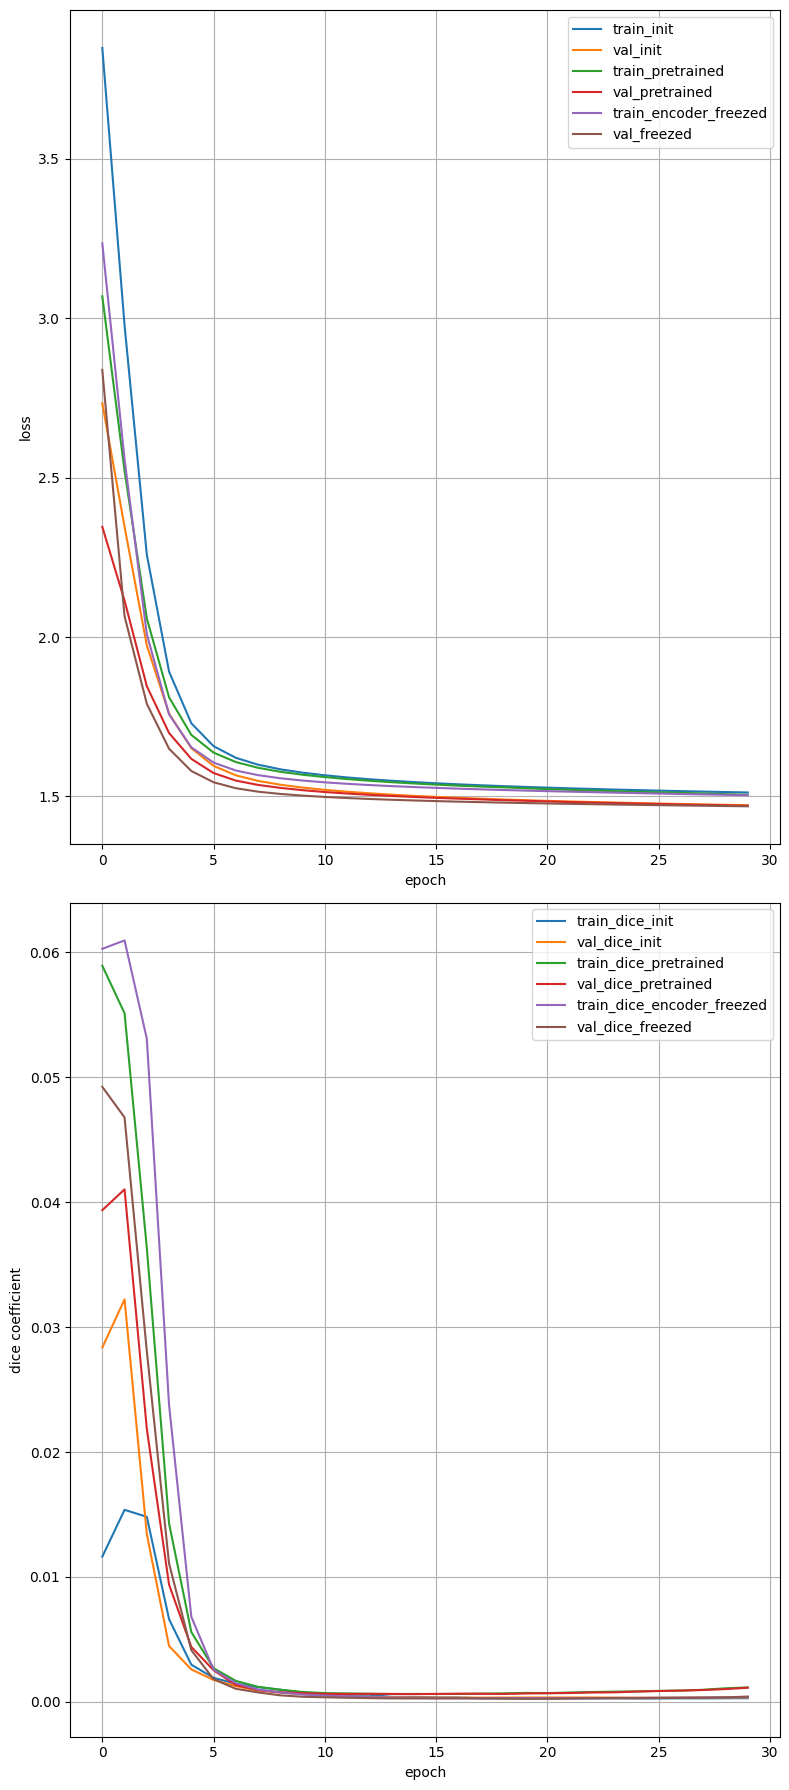

In [131]:
plt.figure(figsize=(8, 18))

plt.subplot(211)
plt.plot(train_loss_def, label="train_init")
plt.plot(val_loss_def,  label="val_init")
plt.plot(train_loss_prt, label="train_pretrained")
plt.plot(val_loss_prt,  label="val_pretrained")
plt.plot(train_loss_frz, label="train_encoder_freezed")
plt.plot(val_loss_frz,  label="val_freezed")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid("on")
plt.legend()

plt.subplot(212)
plt.plot(train_dice_coefficient_def, label="train_dice_init")
plt.plot(val_dice_coefficient_def,  label="val_dice_init")
plt.plot(train_dice_coefficient_prt, label="train_dice_pretrained")
plt.plot(val_dice_coefficient_prt,  label="val_dice_pretrained")
plt.plot(train_dice_coefficient_frz, label="train_dice_encoder_freezed")
plt.plot(val_dice_coefficient_frz,  label="val_dice_freezed")
plt.xlabel("epoch")
plt.ylabel("dice coefficient")
plt.grid("on")
plt.legend()
plt.tight_layout()